# Introduction

In [1]:
from glob import glob
from math import ceil, sqrt
import os

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
limited
import dataset
import tfutil as tfu

## A Look at the Data
To check the data was read correctly, I display a random sample of training images.

In [2]:
tf.reset_default_graph()

with tf.Session() as sess:
    images, labels = dataset.inputs(name='train', batch_size=16, display=True)
    
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    sample_images, sample_labels = sess.run([images, labels])
    sample_labels = sample_labels.reshape([16])
    
    coord.request_stop()
    coord.join(threads)

/usr/lib64/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


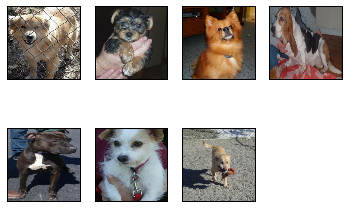

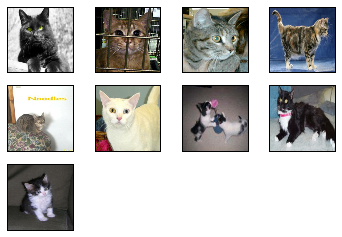

In [3]:
sample_cats = sample_images[sample_labels == 1]
sample_dogs = sample_images[sample_labels == 0]

cat_figure = plt.figure()
for i in range(len(sample_cats)):
    sub = cat_figure.add_subplot(ceil(len(sample_cats)/4), 4, i+1)
    
    # disable axes markings
    sub.set_xticks(())
    sub.set_yticks(())
    
    sub.imshow(sample_cats[i].reshape(dataset.image_dim(include_channels=True)))
cat_figure.show()

dog_figure = plt.figure()
for i in range(len(sample_dogs)):
    sub = dog_figure.add_subplot(ceil(len(sample_dogs)/4), 4, i+1)
    
    # disable axes markings
    sub.set_xticks(())
    sub.set_yticks(())
    
    sub.imshow(sample_dogs[i].reshape(dataset.image_dim(include_channels=True)))
dog_figure.show()

### Predict All Dogs
To provide a baseline for comparison (and to check the composition of our data is ok following the train/validation/test split), I check the performance of a predictor which labels every image as a dog. (And indeed this predictor gets about 50% accuracy as expected.)

In [4]:
def all_dog_inference_op(images):
    return tf.Variable(trainable=False, dtype=tf.float32, initial_value=tf.ones(shape=[images.shape[1]], dtype=tf.float32))

tf.reset_default_graph()

valid_images, valid_labels = dataset.inputs(name='validation', num_epochs=None)
valid_logits = all_dog_inference_op(valid_images)
valid_accuracy_op = tfu.accuracy_op(valid_logits, valid_labels, name='validation')
    
test_images, test_labels = dataset.inputs(name='test', num_epochs=None)
test_logits = all_dog_inference_op(test_images)
test_accuracy_op = tfu.accuracy_op(test_logits, test_labels, name='test')

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sess.run(init_op)
    
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

try:
    valid_accuracy = tfu.avg_op(sess, valid_accuracy_op)
    print('Validation accuracy: {acc:.1%}'.format(acc=valid_accuracy))
    test_accuracy = tfu.avg_op(sess, test_accuracy_op)
    print('Test accuracy: {acc:.1%}'.format(acc=test_accuracy))
except tf.errors.OutOfRangeError:
    pass
finally:
    coord.request_stop()
    
coord.join(threads)
sess.close()

Validation accuracy: 48.2%
Test accuracy: 49.0%
